In [37]:
import pyarrow.feather as feather
import pandas as pd
import numpy as np
from scipy.io import netcdf
import matplotlib.pyplot as plt 
from shapely.geometry import Point
import geopandas as gpd
from geopandas import GeoDataFrame
import xarray as xr
import netCDF4 as nc
from netCDF4 import Dataset
import xlrd

import warnings
warnings.filterwarnings("ignore")

### important!! for next use, pen bgr_location.csv to add more idx to it- not the metadata

In [2]:
# import meta_data for the lat and long of bgr stations
#meta_df = pd.read_excel("dataset/meta_data/metadata_timeseries_LongLat.xlsx")
#bgr_location = meta_df[["proj_id","x_long","y_lat"]].sort_values("proj_id")
#bgr_location = bgr_location.rename(columns={"x_long":"bgr_long","y_lat":"bgr_lat"})
#bgr_location.head()

In [3]:
# open a sample nc file to extract the weather stations lat/long
dir_01_2005 = "dataset/temperature/data/"+'daily_Project_TRY_air_temperature_mean__TT_200511_daymean.nc'
nc = netcdf.NetCDFFile(dir_01_2005,'r')

In [4]:
nc.variables

OrderedDict([('lon', <scipy.io.netcdf.netcdf_variable at 0x7fc71448a9a0>),
             ('lat', <scipy.io.netcdf.netcdf_variable at 0x7fc6d87f9760>),
             ('time', <scipy.io.netcdf.netcdf_variable at 0x7fc6d87f96a0>),
             ('time_bnds',
              <scipy.io.netcdf.netcdf_variable at 0x7fc6d87f9a00>),
             ('datum', <scipy.io.netcdf.netcdf_variable at 0x7fc714483fd0>),
             ('temperature',
              <scipy.io.netcdf.netcdf_variable at 0x7fc714483b80>)])

## the long and lat in the nc files are not coordinates but veriables i.e. there is an coords layer of 720x938x30 (time) which has only int indices and above of it they created the long, lat, temp. therefore we cannot use the normal method f extracting the nearest long and lat 

## I moved to the other approach to extract them using the mathematical function

In [5]:
# long and lat where temp was measured (weather credits)
weather_long = nc.variables["lon"][:].flatten()
weather_lat = nc.variables["lat"][:].flatten()
#temp = temp_01_2005.variables["temperature"][5,:,:].flatten()
weather_df = pd.DataFrame({"long":weather_long,"lat": weather_lat})
weather_df.head()

,long,lat
0,5.5452,46.7198
1,5.5587,46.7204
2,5.5722,46.7209
3,5.5857,46.7215
4,5.5991,46.7221


In [118]:
# onther func to compute the dist, but haversine formula more accurate
"""def distance(w):
    
    pt_1 = np.array((w[0], w[1]))
    pt_2 = np.array((bgr[0], bgr[1]))
    return np.linalg.norm(pt_1-pt_2)

"""

In [12]:
# compute the dist in km between any two points on the sphere surface
# depending on the long/lat (haversine formula)

def distance(w):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    """
    lon1, lat1 = w[0], w[1]
    lon2, lat2 = bgr[0],bgr[1]
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    km = 6367 * c
    return km


# the next run take the next 1000 or 2000 bgr station

In [33]:
# check the csv
bgr_location = pd.read_csv("dataset/meta_data/bgr_location.csv")
bgr_location.iloc[2995:3005]

,proj_id,bgr_long,bgr_lat,idx
2995,BW_199-258-0,8.489523,49.107647,178783
2996,BW_199-772-7,10.053499,47.764407,73773
2997,BW_2-114-0,7.846183,48.585176,139136
2998,BW_2-509-4,9.177204,49.085207,176671
2999,BW_2-568-8,9.483746,48.147846,103972
3000,BW_2-667-0,9.831805,48.238631,0
3001,BW_20-020-0,7.596976,47.916984,0
3002,BW_20-520-3,9.223661,47.916475,0
3003,BW_20-568-5,9.454208,48.129486,0
3004,BW_200-258-7,8.489155,49.107421,0


In [14]:
# compute the nearest dist to each bgr station
for i in range(1000,3000):
    #choose a bgr station
    bgr = bgr_location["bgr_long"][i],bgr_location["bgr_lat"][i]
    # compute the distances to each weather credits
    weather_df["dist"]=weather_df.apply(distance, axis =1)
    # match the index of the weather credit to the corresponding bgr station
    bgr_location["idx"].iloc[i]=np.argmin(weather_df["dist"])
    #print(np.min(weather_df["dist"]))
    
print("done")

/home/basem/anaconda3/envs/bgr/lib/python3.8/site-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


done


In [25]:
# get the stored indices 
idx = bgr_location["idx"][0:3000]
# check the resulted indices
bgr_location.iloc[2000:2005]

,proj_id,bgr_long,bgr_lat,idx
2000,BW_10-619-2,9.540174,48.010910,93176
2001,BW_100-020-4,7.617715,47.998087,93758
2002,BW_100-063-5,7.828001,48.603246,140575
2003,BW_100-068-0,7.768975,48.169478,106729
2004,BW_100-069-1,7.799146,48.099071,101691


Text(0.5, 1.0, 'lat')

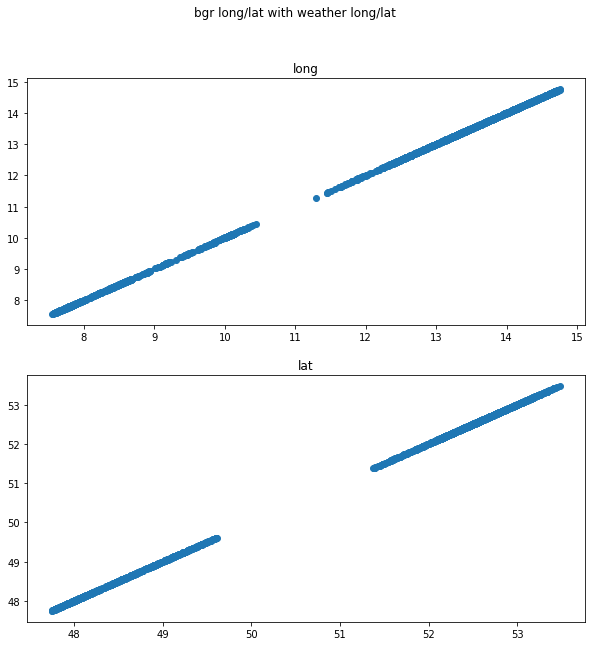

In [34]:
fig, axs = plt.subplots(2, 1, figsize=(10,10))
fig.suptitle('bgr long/lat with weather long/lat ')
axs[0].scatter(weather_df["long"].iloc[idx],  bgr_location["bgr_long"][0:3000])
axs[0].set_title('long')
axs[1].scatter(weather_df["lat"].iloc[idx],  bgr_location["bgr_lat"][0:3000])
axs[1].set_title('lat')

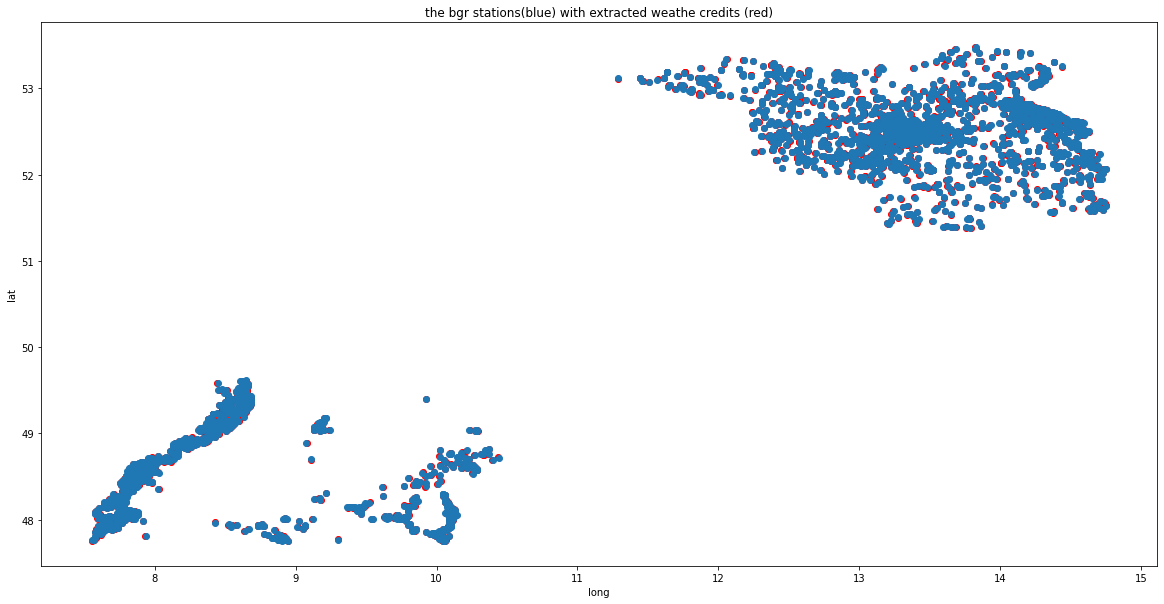

In [35]:
plt.figure(figsize=(20,10))
plt.scatter(bgr_location["bgr_long"][0:3000], bgr_location["bgr_lat"][0:3000],color="red")
plt.scatter(weather_df["long"].iloc[idx], weather_df["lat"].iloc[idx])
plt.xlabel('long')
plt.ylabel('lat')
plt.title("the bgr stations(blue) with extracted weathe credits (red)")
plt.show()

In [32]:
# store changes into csv
bgr_location.to_csv("dataset/meta_data/bgr_location.csv", index =0)

In [155]:
# check the csv
pd.read_csv("dataset/meta_data/bgr_location.csv")

,proj_id,bgr_long,bgr_lat,idx
0,BB_25470023,13.643609,53.416804,516084
1,BB_25470024,13.643653,53.416793,516084
2,BB_25480025,13.826532,53.452024,518975
3,BB_25480026,13.677407,53.457078,518966
4,BB_25481088,13.821475,53.475857,521135
...,...,...,...,...
13487,TH_5633900046,11.197713,50.333011,0
13488,TH_5633900056,11.196891,50.344423,0
13489,TH_5633900114,11.263650,50.362301,0
13490,TH_5729240555,10.634292,50.237109,0


In [ ]:
##################################################################################################################